In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import collections
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
import glob
import gc

/zhome/0f/8/221869/miniforge3/envs/text-embeddings/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read Data from Parquet


Pfad Parquet File: /dtu/blackhole/1a/222266/embeddings.parquet

In [2]:
# read data from parquet file
path_book_ratings = "/dtu/blackhole/1a/222266/Books_rating_embeddings"


In [3]:
in_dir = Path(path_book_ratings)
files = sorted(glob.glob(str(in_dir / "*.parquet")))
#use_files = files[:NUM_FILES]

in_dir = Path(path_book_ratings)
if not in_dir.exists():
    raise FileNotFoundError(f"Ordner nicht gefunden: {in_dir}")

In [4]:
print(files)

['/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00000.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00001.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00002.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00003.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00004.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00005.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00006.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00007.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00008.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00009.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00010.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00011.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00012.parquet', '/dtu/blackhole/1a/222266/Books_rating_embeddings/part-00013.parquet', '/dtu

In [5]:
def extract_all_columns_as_df(fp: str):
    """Return the full Parquet file as a pandas DataFrame."""
    return pq.read_table(fp).to_pandas()

In [13]:
dfs = []
for fp in files:
    df = extract_all_columns_as_df(fp)
    dfs.append(df)

# Combine into one large DataFrame
df_all = pd.concat(dfs, ignore_index=True)

print(f"Fertige DataFrame-Form: {df_all.shape}")
print(df_all.head())

ArrowMemoryError: realloc of size 33554432 failed

In [7]:
print(df_all.shape)

(2968263, 4)


In [8]:
# get subset of data for clustering
df_subset = df_all.sample(n=100000, random_state=42)
embeddings = np.vstack(df_subset['embedding'].values)

In [9]:
# delete OG dataframe after creating subset to free up memory
del df_all
gc.collect()

58908

In [12]:
del embeddings
del X_reduced
gc.collect()

0

## K-means with k = 5
Todo: 
- try different number of clusters ✅
- Compute average score/score distribution per cluster
- Try different Hyperparameters for UMAP
- Try t-SNE
- Compute score for Clustering

Todo neu:
- anzahl k für ganzes datenset in .py
- anzahl pro cluster
- heatmap 
- mean, sd, quantiles per cluster

In [10]:
#try clustering the embeddings
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# Fit KMeans on embeddings
labels = kmeans.fit_predict(embeddings)

# labels[i] is the cluster of embeddings[i]
print(labels[:20])  # show the first 20 cluster assignments

# Add cluster labels to the original dataframe
df_subset["cluster"] = labels

# See cluster counts
print(df_subset["cluster"].value_counts())

[3 3 0 0 1 3 2 3 0 0 0 0 1 2 3 0 3 1 2 1]
cluster
3    2375
0    2155
4    2148
2    1751
1    1571
Name: count, dtype: int64


In [11]:
df_subset.head

<bound method NDFrame.head of              row_id review/score  \
1574863  B000HYTF96          5.0   
2694301  B000Q9I494          5.0   
1069238  B00085ZGFG          5.0   
2438560  B000E1EJ3Y          4.0   
348515   B0007HVO0Q          1.0   
...             ...          ...   
133098   B000JCVP30          5.0   
1829335  0316848662          4.0   
166283   B00005VO13          4.0   
2539586  0785731261          5.0   
835550   0316748641          4.0   

                                                 cleanText  \
1574863  I took this book on vacation thinking that I w...   
2694301  hey, ive been wondering why was tom bombadil e...   
1069238  "Crime and Punishment" was my introduction to ...   
2438560  This book asks some interesting questions in s...   
348515   Quantim mechanics in general requires high lev...   
...                                                    ...   
133098   This book is quite possibly the best Vonnegut ...   
1829335  'Resurrection Day' is an alterna

Normalized review score distribution per cluster:
review/score       1.0       2.0       3.0       4.0       5.0
cluster                                                       
0             0.051214  0.036072  0.087132  0.247855  0.577726
1             0.085294  0.079472  0.121034  0.215605  0.498594
2             0.080612  0.050476  0.075154  0.182637  0.611121
3             0.077530  0.053441  0.081984  0.183266  0.603779
4             0.038529  0.024164  0.047763  0.149497  0.740047

Absolute review score counts per cluster:
review/score   1.0   2.0   3.0   4.0    5.0
cluster                                    
0              991   698  1686  4796  11179
1             2124  1979  3014  5369  12416
2             1728  1082  1611  3915  13100
3             1149   792  1215  2716   8948
4              751   471   931  2914  14425


<Figure size 1000x600 with 0 Axes>

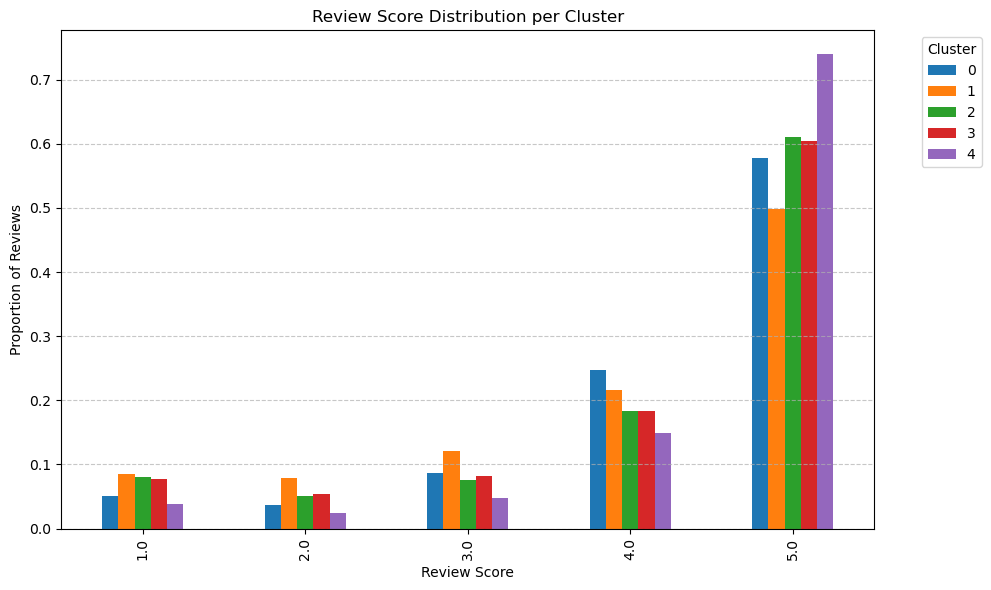

In [12]:
# --- Group by cluster and compute score distribution ---
score_counts = df_subset.groupby("cluster")["review/score"].value_counts(normalize=True).unstack(fill_value=0)

print("Normalized review score distribution per cluster:")
print(score_counts)

# --- Optional: also get absolute counts ---
score_counts_abs = df_subset.groupby("cluster")["review/score"].value_counts().unstack(fill_value=0)
print("\nAbsolute review score counts per cluster:")
print(score_counts_abs)

# --- Plot the distributions ---
plt.figure(figsize=(10, 6))
score_counts.T.plot(kind="bar", figsize=(10, 6))
plt.title("Review Score Distribution per Cluster")
plt.xlabel("Review Score")
plt.ylabel("Proportion of Reviews")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

/zhome/0f/8/221869/miniforge3/envs/text-embeddings/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


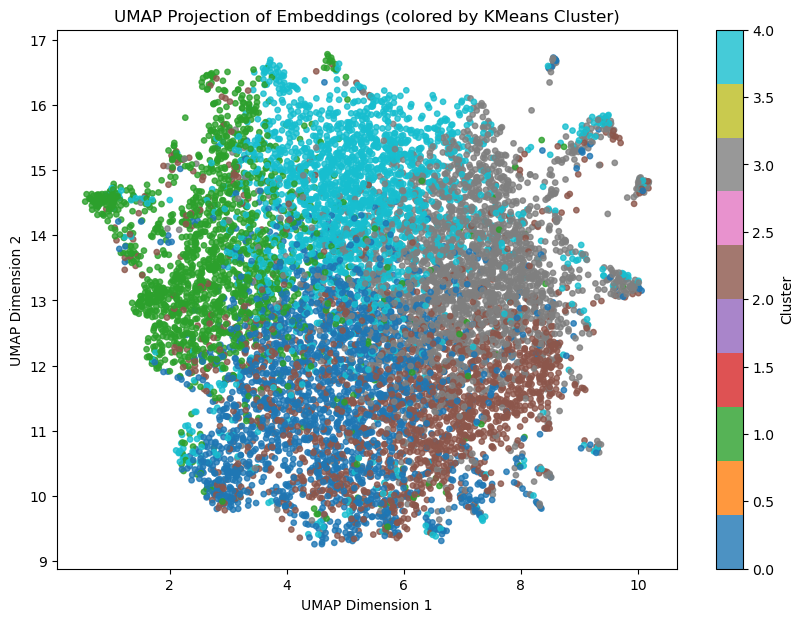

In [11]:

reducer = umap.UMAP(n_neighbors=20, min_dist=0.3, random_state=42, init='random')
embedding_2d = reducer.fit_transform(embeddings)

# --- Visualization ---
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=labels,
    cmap='tab10',  # or 'Spectral', 'viridis', etc.
    s=15,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.title("UMAP Projection of Embeddings (colored by KMeans Cluster)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [12]:

reducer = umap.UMAP(n_neighbors=20, min_dist=0.3, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# --- Visualization ---
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=labels,
    cmap='tab10',  # or 'Spectral', 'viridis', etc.
    s=15,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.title("UMAP Projection of Embeddings (colored by KMeans Cluster)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.savefig("umap_clusters.png", dpi=300)  # high-quality PNG
plt.close()  # close the figure to free memory

/zhome/0f/8/221869/miniforge3/envs/text-embeddings/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/zhome/0f/8/221869/miniforge3/envs/text-embeddings/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


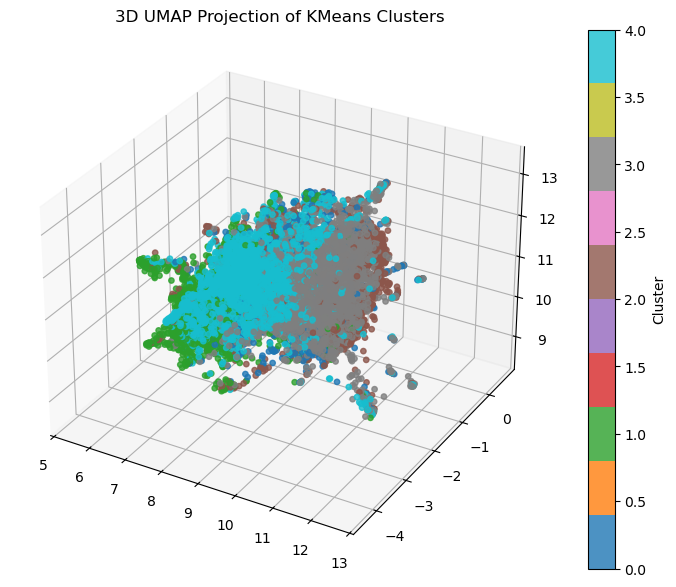

In [18]:
from mpl_toolkits.mplot3d import Axes3D

reducer_3d = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
               c=labels, cmap='tab10', s=15, alpha=0.8)
fig.colorbar(p, label='Cluster')
ax.set_title("3D UMAP Projection of KMeans Clusters")
plt.show()


## Compute Davies-Bouldin Index

In [14]:
# Compute Davies
# Compute Davies–Bouldin Index
db_index = davies_bouldin_score(embeddings, labels)
print(f"Davies–Bouldin Index: {db_index:.4f}")

Davies–Bouldin Index: 4.9531


## K-means with k = [2, 10]


k= 2 | Davies–Bouldin Index=4.7039 | Inertia=861504.75
k= 3 | Davies–Bouldin Index=4.7863 | Inertia=844909.31
k= 4 | Davies–Bouldin Index=4.9967 | Inertia=833017.25
k= 5 | Davies–Bouldin Index=4.9531 | Inertia=824285.38
k= 6 | Davies–Bouldin Index=4.8639 | Inertia=817274.62
k= 7 | Davies–Bouldin Index=4.7333 | Inertia=811007.56
k= 8 | Davies–Bouldin Index=4.6301 | Inertia=804819.25
k= 9 | Davies–Bouldin Index=4.7225 | Inertia=800056.62
k=10 | Davies–Bouldin Index=4.6977 | Inertia=795580.94


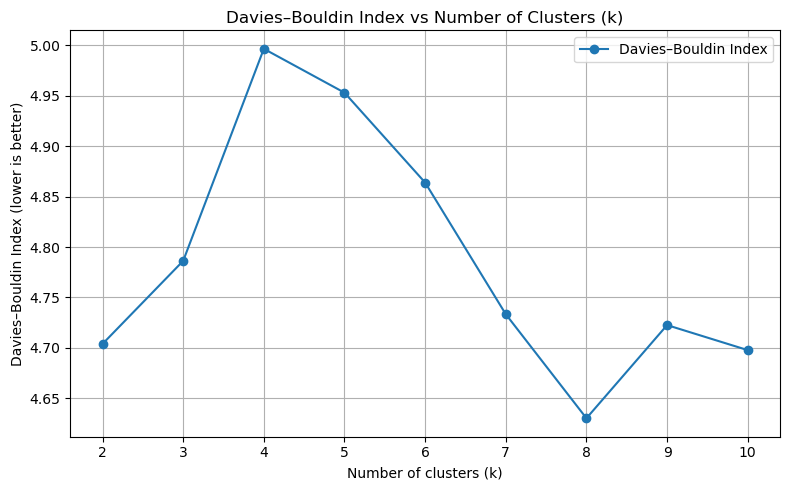

In [15]:
# === Step 2: Run KMeans for k = 2..10 and compute Davies–Bouldin Index ===
k_values = range(2, 11)
db_scores = []
inertias = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    db_index = davies_bouldin_score(embeddings, labels)
    inertia = kmeans.inertia_

    db_scores.append(db_index)
    inertias.append(inertia)

    print(f"k={k:2d} | Davies–Bouldin Index={db_index:.4f} | Inertia={inertia:.2f}")

# === Step 3: Plot the results ===
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker='o', linestyle='-', label='Davies–Bouldin Index')
plt.title("Davies–Bouldin Index vs Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin Index (lower is better)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
X = StandardScaler().fit_transform(embeddings)
labels = dbscan.fit_predict(X)

## DBSCAN

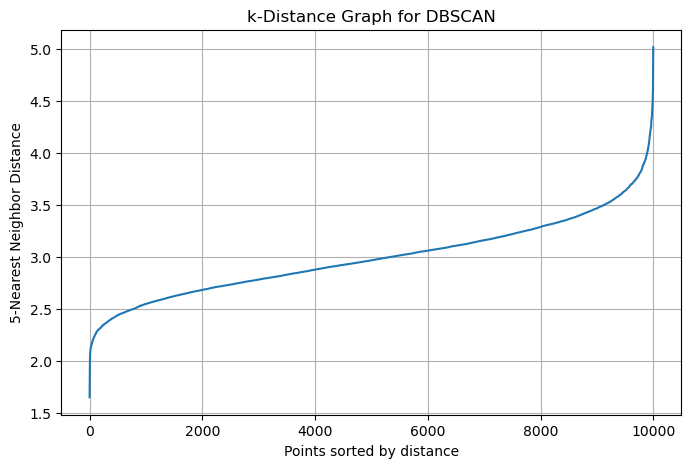

In [13]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Suppose your data is in a NumPy array called X
k = 5  # typically min_samples for DBSCAN or min_samples - 1
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

# Sort the distances to the kth nearest neighbor
distances = np.sort(distances[:, k-1])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title("k-Distance Graph for DBSCAN")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-Nearest Neighbor Distance")
plt.grid(True)
plt.show()


In [10]:
pca = PCA(n_components=100, random_state=42)
X_reduced = pca.fit_transform(embeddings)
explained_var = np.sum(pca.explained_variance_ratio_) * 100
print(f"PCA done. Retained {explained_var:.2f}% variance.")

PCA done. Retained 83.67% variance.


In [11]:
# Configure DBSCAN
#scaler = StandardScaler()
#embeddings_scaled = scaler.fit_transform(embeddings)
dbscan = DBSCAN(
    eps=2.6,       # max distance between samples in a cluster, tune this
    min_samples=20, # minimum number of samples to form a cluster
    metric='euclidean',  # distance metric
    n_jobs=-1      # use all cores
)
# Fit DBSCAN
labels = dbscan.fit_predict(X_reduced)

# Add cluster labels back to your dataframe
df_subset['cluster_db'] = labels

# Quick summary
print(df_subset["cluster_db"].value_counts().sort_index())

cluster_db
-1    14726
 0    85274
Name: count, dtype: int64


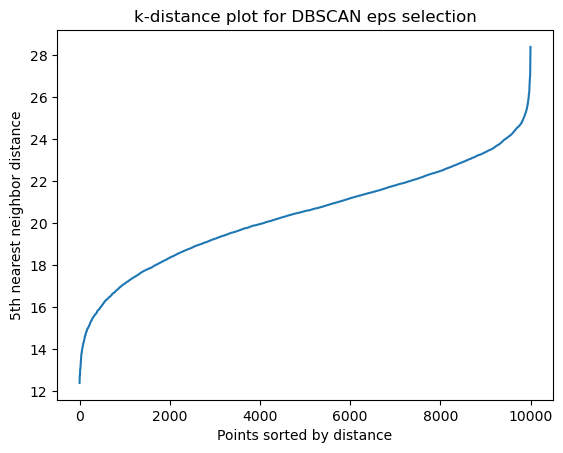

In [33]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)  # min_samples = 5
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 4])  # 4 because 0-indexed

plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th nearest neighbor distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.show()


In [31]:
# Sample points: three obvious clusters
points = np.array([
    [1, 2], [1.1, 2.1], [0.9, 1.8],   # cluster 1
    [8, 8], [8.2, 7.9], [7.9, 8.1],   # cluster 2
    [5, 0], [5.1, 0.1], [4.9, -0.1],  # cluster 3
    [20, 20]                           # noise
])

# Optional: scale if you want
scaler = StandardScaler()
points_scaled = scaler.fit_transform(points)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)
labels = dbscan.fit_predict(points_scaled)

# Show results
df = pd.DataFrame(points, columns=['x', 'y'])
df['cluster'] = labels
print(df)

      x     y  cluster
0   1.0   2.0        0
1   1.1   2.1        0
2   0.9   1.8        0
3   8.0   8.0        1
4   8.2   7.9        1
5   7.9   8.1        1
6   5.0   0.0        2
7   5.1   0.1        2
8   4.9  -0.1        2
9  20.0  20.0       -1


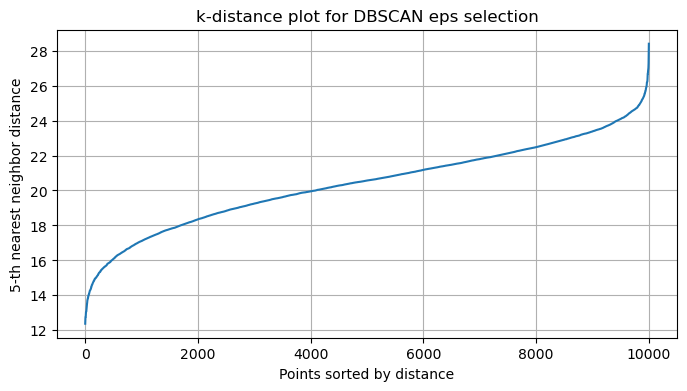


Cluster label counts:
cluster_dbscan
-1    10000
Name: count, dtype: int64

Number of clusters found: 0
Number of noise points: 10000


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# --- Step 1: Prepare embeddings ---
"""
if "embedding" in br.columns:
    embeddings = np.vstack(br["embedding"].values)
else:
    embeddings = br.select_dtypes(include=[float, int]).values

print("Embeddings shape:", embeddings.shape)

"""
# --- Step 2: Scale embeddings (important for distance-based clustering) ---
X = StandardScaler().fit_transform(embeddings)



# --- Step 3: Compute k-distance to estimate eps ---
min_samples = 5  # you can adjust this
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, min_samples - 1])  # 0-indexed
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-th nearest neighbor distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.grid(True)
plt.show()

# --- Step 4: Choose eps based on the "knee" of the plot ---
# Manual inspection: pick eps where the curve sharply increases
# Example: eps = 0.5 (adjust after inspecting the plot)
eps = 0.5
min_samples = 5

# --- Step 5: Run DBSCAN ---
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
labels = dbscan.fit_predict(X)

# --- Step 6: Add cluster labels to DataFrame ---
br["cluster_dbscan"] = labels

# --- Step 7: Inspect results ---
print("\nCluster label counts:")
print(br["cluster_dbscan"].value_counts().sort_index())

n_noise = (labels == -1).sum()
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"\nNumber of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")


In [2]:
path = '/dtu/blackhole/1a/222266/clustered_reviews.csv'
# read data from csv file
df_clustered = pd.read_csv(path)
print(df_clustered.head())

    review_id  rating  cluster
0  1882931173     4.0        4
1  0826414346     5.0        0
2  0826414346     5.0        0
3  0826414346     4.0        0
4  0826414346     4.0        0


In [ ]:
# do umap on clustered data